**INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent the problems while reloading the Project. The third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING THE DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the Project in one particular cell.

In [3]:
#@ DOWNLOADING THE DEPENDENCIES: UNCOMMENT BELOW:
# !pip install kora -q                                        # Installing the Dependencies for RDKIT.
import kora.install.rdkit                                     # Getting RDKIT. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import r2_score

In [5]:
#@ INSTALLING THE SMILES VECTORIZER: UNCOMMENT BELOW:
# %cd /content/drive/MyDrive/Colab Notebooks
# !git clone https://github.com/EBjerrum/molvecgen                  # Cloning the repository. 
# %cd /content/drive/MyDrive/Colab Notebooks/molvecgen
# !python setup.py install                                          # Installing the Dependencies.  
from molvecgen.vectorizers import SmilesVectorizer                  # Importing the Vectorizer. 

**GETTING THE DATA:**
- I have downloaded the dataset from [ExcapeDB](https://solr.ideaconsult.net/search/excape/). **ExcapeDB** is a project developed as a part of **BigChem**. I will read the data using pandas and manage the dataset.

In [6]:
#@ GETTING THE DATA:
PATH = "/content/drive/MyDrive/WORK/Data.csv"                  # Path to the Data.
data = pd.read_csv(PATH)                                       # Reading the Data.
data.head()                                                    # Inspecting the Data. 

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZMKBJHIXZCVNL-BXKDBHETNA-N,44590643,6532,A,5.68382,pubchem,393260,9606,SLC6A4,4061,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1
1,AZMKBJHIXZCVNL-UHFFFAOYNA-N,11492305,6532,A,5.16210,pubchem,393258,9606,SLC6A4,4061,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1
2,AZOHUEDNMOIDOC-GETDIYNLNA-N,44419340,6532,A,6.66354,pubchem,276059,9606,SLC6A4,4061,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...
3,AZSKJKSQZWHDOK-VJSLDGLSNA-N,CHEMBL1080745,6532,A,6.96000,chembl20,617082,9606,SLC6A4,4061,C=1C=C(C=CC1)C2=CC(=C(N2CC(C)C)C)C(NCCCN3CCN(C...
4,AZTPZTRJVCAAMX-UHFFFAOYNA-N,CHEMBL578346,6532,A,8.00000,chembl20,596934,9606,SLC6A4,4061,C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2


### **PREPARING THE DATA:**

,SMILES,Molecule
0,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1,
1,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1,
2,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...,

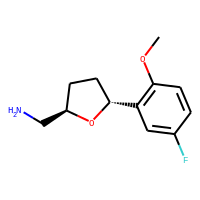
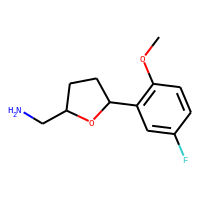
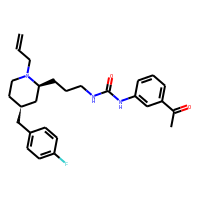

In [7]:
#@ DATA EXPLORATION:
PandasTools.AddMoleculeColumnToFrame(data, "SMILES", "Molecule")
data[["SMILES", "Molecule"]].head(3)                                    # Inspecting the Data.

**VECTORIZING THE MOLECULES:**
- I will be using **Molvecgen Package** to vectorize the smiles. The object is initialized with the generation parameters and subsequently fitted to the dataset which analyzes for what characters it contains the maximal length. 

In [8]:
#@ VECTORIZING THE MOLECULES WITH DATA AUGMENTATION:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True) # Initializing the Smiles Vectorizer. 
smivec.fit(data.Molecule.values, )                                            # Implementation of the Vectorizer. 
print(smivec.charset)                                                         # Inspecting the Character set. 
print(smivec.dims)                                                            # Inspecting the Dimensions of Onehot Encoded Smiles. 

3B#cn/7NO(]4\o2rFHS6@1-)CIs85l[+=^$?
(127, 36)


**PREPARING THE DATA:**
- **PyTorch** needs to be trained on tensors. I will divide the dataset into train, validation and test dataset using **Scikit Learn**. 

In [9]:
#@ PREPARING THE DATA:
y = data.pXC50.values.reshape((-1, 1))                                    # Reshaping the Dataset. 
X = data.Molecule.values                                                  # Preparing the Data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                    random_state=11)                      # Splitting the Dataset into Training set and Test set. 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                    test_size=0.05, random_state=11)      # Splitting the Training set into Train and Validation set. 
#@ NORMALIZATION:
scaler = StandardScaler()                                                 # Initializing the Standard Scaler. 
y_train = scaler.fit_transform(y_train)                                   # Normalizing the Data.
y_test = scaler.transform(y_test)                                         # Normalizing the Data.
y_valid = scaler.transform(y_valid)                                       # Normalizing the Data.                                 

**DATASET CLASS:**
- **PyTorch** works with datasets. I will integrate the vectorizer using subclassing which allow us to load the dataset using **Rdkit** molecular objects and generate the tensors. 

In [10]:
#@ INTEGRATING THE VECTORIZER IN DATASET CLASS:
class SMILESDataset(Dataset):                                     # Dataset Class. 
  def __init__(self, molecules, y, vectorizer):
    self.molecules = molecules
    self.y = y
    self.vectorizer = vectorizer
  def __len__(self):                                              # Subclassing the method. 
    return len(self.molecules)
  def __getitem__(self, idx):                                     # Subclassing the method. 
    if torch.is_tensor(idx):
      idx = idx.tolist()
    mols = self.molecules[idx]
    sample = self.vectorizer.transform([mols])[0]
    label = self.y[idx]
    return sample, label
#@ CREATING THE DATASET:
train_dataset = SMILESDataset(X_train, y_train, smivec)           # Invoking the SMILESDataset Class. 
train_dataset[0]                                                  # Inspecting the Dataset. 

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8), array([-0.19724555]))

**PREPARING THE DATA:**


In [11]:
#@ PREPARING THE DATA:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")      # Inspecting if CUDA is available. 
X_valid_t = smivec.transform(X_valid, canonical=False)                     # Vectorization. 
X_valid_t = torch.tensor(X_valid_t, device=device).float()                 # Converting into Float Tensors. 
y_valid_t = torch.tensor(y_valid, device=device).float()                   # Converting into Float Tensors. 
print(X_valid_t.shape, y_valid_t.shape)                                    # Inspecting the Data. 

torch.Size([326, 127, 36]) torch.Size([326, 1])


### **BUILDING THE MODEL:**
- I will define the **LSTM Neural Network** architecture. 

In [12]:
#@ LSTM MOLECULAR MODEL: 
class Net(nn.Module):                                                                      # LSTM Molecular Model. 
  def __init__(self, dimensions, lstm_size, hidden_size, dropout_size, output_size):
    super(Net, self).__init__()
    length = dims[0]
    number_tokens = dims[1]
    self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, 
                        batch_first=True, bidirectional=False)                             # LSTM Layer. 
    self.fc1 = nn.Linear(lstm_size, hidden_size)                                           # Simple Linear Layer. 
    self.activation = nn.ReLU()                                                            # Non Linear RELU Layer. 
    self.fc_out = nn.Linear(hidden_size, output_size)                                      # Output Layer.      
    self.dropout = nn.Dropout(dropout_size)                                                # Dropout Layer. 
  def forward(self, x):                                                                    # Stacking each layer together. 
    out, (h_n, c_n) = self.lstm(x)                                                         # LSTM Network reads the onehot encoded SMILES. 
    out = self.dropout(h_n)                                                                # Defining the Dropout. 
    out = self.fc1(out)                                                                    # Passing into the Hidden Layer. 
    out = self.activation(out)                                                             # Using RELU Activation.
    out = self.dropout(out)                                                                # Defining the Dropout. 
    out = self.fc_out(out)                                                                 # Using the Linear Layer for Output. 
    return out
#@ DEFINING THE PARAMETERS:
epochs = 750
dims = smivec.dims
lstm_size = 128                                                                            # Size of the LSTM Layer. 
hidden_size = 128                                                                          # Size of the Hidden Non Linear Layer. 
dropout_rate = 0.50                                                                        # The Dropout Rate. 
output_size = 1                                                                            # Single Task. 
batch_size = 128                                                                           # Minibatch size during Training. 
learning_rate = 0.003                                                                      # Initial Learning Rate for the Optimizer. 
#@ LSTM MOLECULAR MODEL:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)                     # Instantiating the Model. 
model.cuda()

Net(
  (lstm): LSTM(36, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
#@ INSPECTING THE MODEL:
pred = model.forward(X_valid_t[10:11])                          # Implementing the Model. 
pred                                                            # Inspecting the result. 

tensor([[[0.0567]]], device='cuda:0', grad_fn=<AddBackward0>)

**PROCESSING THE MODEL:**

In [14]:
#@ PROCESSING THE MODEL:
criterion = nn.MSELoss()                                                                     # Initializing the Loss Function.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                           # Initializing the Optimizer. 
lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=50,
                                 verbose=True, threshold=0.0001, threshold_mode="rel", 
                                 cooldown=0, min_lr=1e-6, eps=1e-08)
#@ PROCESSING THE DATA:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,                            # Preparing the Dataset Loader. 
                                           batch_size=batch_size,
                                           shuffle=True, num_workers=4)
#@ INSPECTING THE TRAIN LOADER:
for smiles, labels in train_loader:
  break

**TRAINING THE MODEL:**


In [15]:
#@ TRAINING THE MODEL:
model.train()                                                                         # Ensuring the Network in Train Mode. 
train_losses = []                                                                     # Initializing the empty list.
validation_losses = []                                                                # Initializing the empty list. 
for i in range(epochs):
  running_loss = 0
  for smiles, labels in train_loader:
    smiles = torch.tensor(smiles, device=device).float()                              # Converting into GPU Tensors. 
    labels = torch.tensor(labels, device=device).float()                              # Converting into GPU Tensors. 
    optimizer.zero_grad()                                                             # Initializing the Gradients. 
    output = model(smiles)                                                            # Forward pass of the Minibatch. 
    loss = criterion(output, labels)                                                  # Computing the Loss. 
    loss.backward()                                                                   # Calculating the Backward Pass. 
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()                                                                  # Optimizing the Gradients. 
    running_loss += loss.item()
  else:
    model.eval()                                                                      # Ensuring the Network in Evaluation Mode. 
    validation_loss = torch.mean((y_valid_t - model(X_valid_t))**2, ).item()          # Calculating the Loss. 
    model.train()                                                                     # Network in Train Mode and Dropout in Active Mode. 
    lr_scheduler.step(validation_loss)                                                # Optimization. 
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)                                                   # Appending the Training Loss. 
    validation_losses.append(validation_loss)                                         # Appending the Validation Loss. 
    if (i + 1) % 10 == 0:
      print("Epoch %i, Training Loss: %0.2F Validation Loss: %0.2F" %(i+1, train_loss, 
                                                                      validation_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([1, 128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target

Epoch 10, Training Loss: 0.85 Validation Loss: 0.89
Epoch 20, Training Loss: 0.78 Validation Loss: 0.77
Epoch 30, Training Loss: 0.70 Validation Loss: 0.76
Epoch 40, Training Loss: 0.66 Validation Loss: 0.70
Epoch 50, Training Loss: 0.61 Validation Loss: 0.66
Epoch 60, Training Loss: 0.57 Validation Loss: 0.60
Epoch 70, Training Loss: 0.55 Validation Loss: 0.60
Epoch 80, Training Loss: 0.51 Validation Loss: 0.56
Epoch 90, Training Loss: 0.48 Validation Loss: 0.53
Epoch 100, Training Loss: 0.45 Validation Loss: 0.53
Epoch 110, Training Loss: 0.43 Validation Loss: 0.49
Epoch 120, Training Loss: 0.43 Validation Loss: 0.47
Epoch 130, Training Loss: 0.41 Validation Loss: 0.49
Epoch 140, Training Loss: 0.38 Validation Loss: 0.52
Epoch 150, Training Loss: 0.37 Validation Loss: 0.49
Epoch 160, Training Loss: 0.37 Validation Loss: 0.44
Epoch 170, Training Loss: 0.36 Validation Loss: 0.44
Epoch 180, Training Loss: 0.35 Validation Loss: 0.42
Epoch 190, Training Loss: 0.35 Validation Loss: 0.42
Ep

**MODEL EVALUATION:**
- I will plot the training now. 

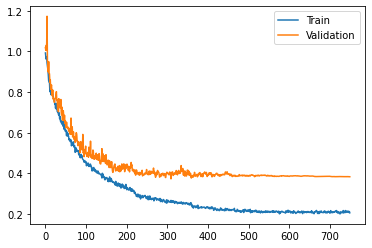

In [16]:
#@ PLOTTING THE TRAINING:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.legend()
plt.show()                                                  # Plotting the Training. 

**MODEL EVALUATION:**
- Before using the model for prediction, it must be set to the evaluation mode, where the dropout layers are no longer active. 

In [17]:
#@ EVALUATING THE PERFORMANCE:
model.eval()                                            # Switching to evaluation mode. 
y_pred_valid = model(X_valid_t)                         # Predicting the Validation Data. 
print(torch.mean((y_valid_t - y_pred_valid)**2).item()) # Inspecting the result. 

0.38341572880744934


**MODEL EVALUATION:**


In [21]:
y_test_t = torch.tensor(y_test, device=device).float()        # Converting into GPU Tensors. 
y_pred_test = model(X_test_t)                                 # Predicting the Test Data. 
y_pred = np.array(y_pred_test.tolist()).flatten()
y_test = np.array(y_test_t.tolist()).flatten()
y_test.shape, y_pred.shape

((723,), (723,))

In [22]:
#@ PROCESSING THE TRAIN AND TEST SET:
X_train_t = smivec.transform(X_train, canonical=False)        # Vectorization. 
X_train_t = torch.tensor(X_train_t, device=device).float()    # Converting into GPU Tensors. 
y_train_t = torch.tensor(y_train, device=device).float()      # Converting into GPU Tensors. 
X_test_t = smivec.transform(X_test, canonical=False)          # Vectorization of Test Dataset. 
X_test_t = torch.tensor(X_test_t, device=device).float()      # Converting into GPU Tensors. 
y_test_t = torch.tensor(y_test, device=device).float()        # Converting into GPU Tensors. 
#@ EVALUATING THE PERFORMANCE:
y_pred_train = model(X_train_t)                               # Predicting the Training Data. 
y_pred_test = model(X_test_t)                                 # Predicting the Test Data. 
train_rmse = torch.mean((y_train_t - y_pred_train)**2).item() # Calculating the RMSE. 
test_rmse = torch.mean((y_test_t - y_pred_test)**2).item()    # Calculating the RMSE.
print("Train RMSE: %0.3F \nTest RMSE: %0.3F" % (train_rmse,
                                                test_rmse))   # Inspecting the RMSE. 
#@ EVALUATING THE PERFORMANCE:
y_test_t= np.array(y_test_t.tolist()).flatten()
y_pred_test= np.array(y_pred_test.tolist()).flatten()
r_square = r2_score(y_test_t, y_pred_test)                    # Calculating the R2. 
print(f"R^2: {r_square}")

Train RMSE: 0.182 
Test RMSE: 1.707
R^2: 0.6529237210980361


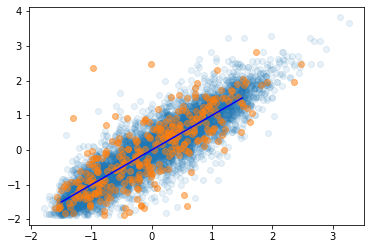

In [23]:
#@ ESTIMATING USING SCATTERPLOT:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_valid.tolist()).flatten(), np.array(y_valid_t.tolist()).flatten(), alpha=0.5)
plt.plot([-1.5, 1.5], [-1.5, 1.5], c="b")
plt.show()